# A predictive approach to estimate the maximum voluntary activation of the shoulder muscles

Romain Martinez<sup>*a</sup>, Jonathan Tremblay<sup>a</sup>, Mickael Begon<sup>a</sup>, Fabien Dal Maso<sup>a</sup>

<sup>a</sup>School of Kinesiology and Exercise Science, Faculty of Medicine, University of Montreal

[GitHub repo](https://github.com/romainmartinez/mvc)

# Part 1: Getting the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import altair as alt

alt.data_transformers.enable("json")

# to make this notebook's output stable across runs
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

In [2]:
PROJECT_PATH = Path("./")
DATA_PATH = PROJECT_PATH / "data"
MODEL_PATH = PROJECT_PATH / "model"

## Read the data

We start this notebook with data in matlab format, where each file corresponds to different experiments.

Each file contains a 3-dimensional matrix where the first dimension corresponds to the _participant_, the second to the _tested muscle_ and the third to the _test performed_.

![Maximum voluntary isometric contraction tests performed.](./share/fig/positions.svg)

In [3]:
mat = {}
data = {key: [] for key in ("dataset", "participant", "muscle", "test", "mvc")}
dataset_names = []
count = -1


for ifile in DATA_PATH.glob("*only_max.mat"):
    # dataset name
    dataset = ifile.stem.replace("_only_max", "").replace("MVE_Data_", "")
    dataset_names.append(dataset)

    # data
    mat[dataset] = sio.loadmat(ifile)["MVE"]
    print(f"project {dataset}: {mat[dataset].shape[0]} participants")

    for iparticipant in range(mat[dataset].shape[0]):
        count += 1
        for imuscle in range(mat[dataset].shape[1]):
            for itest in range(mat[dataset].shape[2]):
                data["participant"].append(count)
                data["dataset"].append(dataset)
                data["muscle"].append(imuscle)
                data["test"].append(itest)
                data["mvc"].append(mat[dataset][iparticipant, imuscle, itest])

project Romain2017: 32 participants
project Landry2015_1: 14 participants
project Landry2012: 18 participants
project Yoann_2015: 22 participants
project Tennis: 16 participants
project Violon: 10 participants
project Patrick_2013: 16 participants
project Landry2015_2: 11 participants
project Landry2016: 15 participants
project Sylvain_2015: 10 participants
project Landry2013: 21 participants


## Transform the data

In [4]:
df_tidy = pd.DataFrame(data).dropna()
df_tidy["test"] = df_tidy["test"].apply(lambda x: f"test {str(x + 1).zfill(2)}")

# MUSCLES = [
#     "upper trapezius",
#     "middle trapezius",
#     "lower trapezius",
#     "anterior deltoid",
#     "middle deltoid",
#     "posterior deltoid",
#     "pectoralis major",
#     "serratus anterior",
#     "latissimus dorsi",
#     "supraspinatus",
#     "infraspinatus",
#     "subscapularis",
# ]

MUSCLES = [
    "upp. trap.",
    "mid. trap.",
    "low. trap.",
    "ant. delt.",
    "mid. delt.",
    "post. delt.",
    "pec. maj.",
    "ser. ant.",
    "lat. dors.",
    "supra.",
    "infra.",
    "subscap.",
]


df_tidy["muscle"] = np.array(MUSCLES)[df_tidy["muscle"]]

print(f"dataset shape = {df_tidy.shape}")
df_tidy.head()

dataset shape = (18465, 5)


,dataset,participant,muscle,test,mvc
0,Romain2017,0,upp. trap.,test 01,0.000381
3,Romain2017,0,upp. trap.,test 04,0.000300
4,Romain2017,0,upp. trap.,test 05,0.000348
5,Romain2017,0,upp. trap.,test 06,0.000111
8,Romain2017,0,upp. trap.,test 09,0.000249


In [5]:
df_wide = df_tidy.pivot_table(
    index=["dataset", "participant", "muscle"],
    columns="test",
    values="mvc",
    fill_value=np.nan,
).reset_index()
df_wide.head()

test,dataset,participant,muscle,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15,test 16
0,Landry2012,46,ant. delt.,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Landry2012,46,lat. dors.,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Landry2012,46,low. trap.,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Landry2012,46,mid. delt.,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Landry2012,46,mid. trap.,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2: Data exploration

In [6]:
df_wide['participant'].nunique()

185

## Muscles and tests count

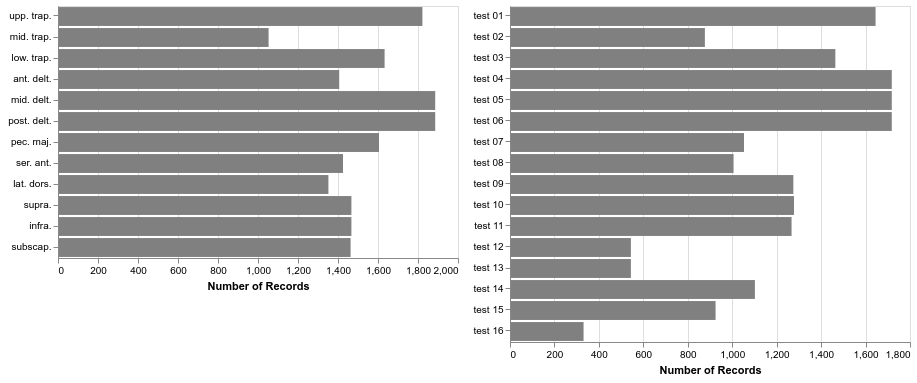

In [7]:
base = alt.Chart(df_tidy).encode(x="count()")
muscle = base.mark_bar(color='grey').encode(alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None))
test = base.mark_bar(color='grey').encode(alt.Y("test", title=None))
(muscle | test)#.properties(title="Number of records by muscle & test")

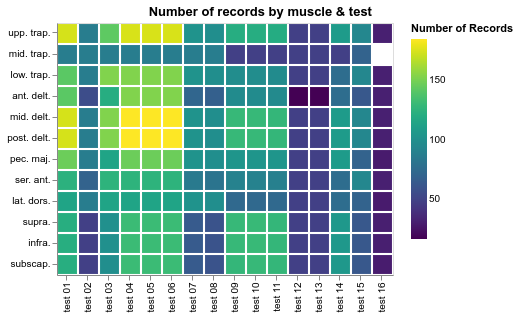

In [8]:
alt.Chart(df_tidy).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    color="count()",
).properties(title="Number of records by muscle & test")

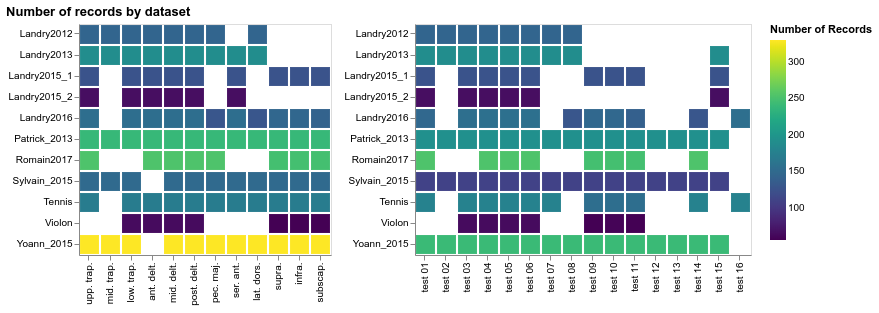

In [9]:
base = alt.Chart(df_tidy).encode(alt.Y("dataset", title=None), color="count()")
test = base.mark_rect().encode(alt.X("test", title=None))
muscle = base.mark_rect().encode(alt.X("muscle", sort=alt.Sort(MUSCLES), title=None))
(muscle | test).properties(title="Number of records by dataset")

## NaNs count

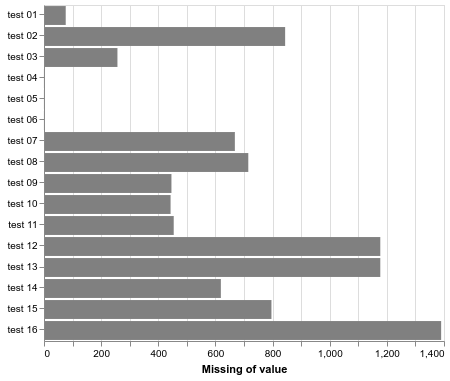

In [10]:
alt.Chart(df_wide.melt(id_vars=["dataset", "participant", "muscle"])).mark_bar(color='grey').encode(
    alt.X("missing(value)"), alt.Y("test", title=None)
)

## Which test normalizes which muscle

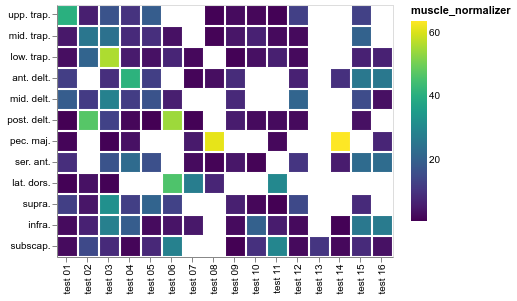

In [11]:
dff = df_tidy.groupby(["test", "muscle"])["mvc"].count().rename("count").to_frame()

max_test = (
    df_tidy.groupby(["participant", "muscle"], as_index=False)
    .apply(lambda x: x["test"][x["mvc"].idxmax()])
    .rename("test")
    .reset_index()
)

dff = dff.merge(
    max_test.groupby(["muscle", "test"]).count().reset_index(), on=["muscle", "test"]
).rename(columns={"participant": "max_test"})


dff["muscle_normalizer"] = dff["max_test"] / dff["count"] * 100

alt.Chart(dff).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    alt.Color("muscle_normalizer"),
)

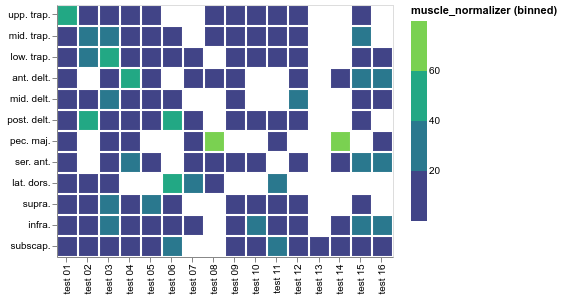

In [12]:
alt.Chart(dff).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    alt.Color("muscle_normalizer", bin=True),
)

# Part 3: Machine learning pipeline

Since tests number 4, 5 and 6 have few missing data (3) and are good normalizers, we will try to predict the maximum obtained with the 16 tests from these three tests alone.

In [13]:
from sklearn.model_selection import GroupShuffleSplit

class Normalize:
    def __init__(self, ref):
        self.ref = ref

    def fit(self, X, y=None):
        self.ref_vector = X[self.ref]
        return self

    def transform(self, X):
        if isinstance(X, pd.core.series.Series):
            return X.multiply(100, axis=0).divide(self.ref_vector, axis=0)
        else:
            X = X.copy()
            num_cols = X.select_dtypes(include="float").columns
            X[num_cols] = (
                X[num_cols].multiply(100, axis=0).divide(self.ref_vector, axis=0)
            )
            return X

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        return X.divide(100, axis=0).multiply(self.ref_vector, axis=0)


def get_X_y_p(d, cols):
    X = d[cols].dropna(subset=cols)
    y = d.select_dtypes(include="float").max(axis=1)
    p = d["participant"].iloc[X.index]

    # remove the top 2.5 percentile
    normalized_y = Normalize(ref="test 05").fit(X).transform(y)
    y = y.loc[normalized_y < normalized_y.quantile(0.975)]
    return X.loc[y.index], y, p.loc[y.index]


def split_data(X, y, p, test_size):
    # we want to make sure that all the data from one participant is in only one set
    train_id, test_id = next(
        GroupShuffleSplit(test_size=test_size, random_state=RANDOM_SEED).split(
            X, groups=p
        )
    )
    return X.iloc[train_id], X.iloc[test_id], y.iloc[train_id], y.iloc[test_id]


def mape_vector(y_true, y_pred):
    return (np.abs((y_pred - y_true) / y_true))


In [14]:
COLS_TO_KEEP = ["muscle", "test 04", "test 05", "test 06"]
TEST_SIZE = 0.2

X, y, p = get_X_y_p(df_wide, COLS_TO_KEEP)

X_train, X_test, y_train, y_test = split_data(X, y, p, test_size=0.2)

float_cols = X.select_dtypes(include="float").columns

norm_train = Normalize(ref="test 05").fit(X_train)
X_train = norm_train.transform(X_train)
y_train = norm_train.transform(y_train)

norm_test = Normalize(ref="test 05").fit(X_test)
X_test = norm_test.transform(X_test)
y_test = norm_test.transform(y_test)

In [15]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=False, random_seed=RANDOM_SEED)
model.fit(X_train, y_train, cat_features=[0])

In [16]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [17]:
train_eval = (
    mape_vector(y_train, y_pred_train)
    .rename("mape")
    .to_frame()
    .assign(muscle=X_train["muscle"], split="train")
)
test_eval = (
    mape_vector(y_test, y_pred_test)
    .rename("mape")
    .to_frame()
    .assign(muscle=X_test["muscle"], split="test")
)

eval_df = pd.concat([train_eval, test_eval])
eval_df.head()

,mape,muscle,split
8,0.171032,ant. delt.,train
9,0.099038,lat. dors.,train
10,0.339732,low. trap.,train
11,0.029067,mid. delt.,train
12,0.320350,mid. trap.,train


In [18]:
eval_df.query('split == "test"').mean()

mape    0.20495
dtype: float64

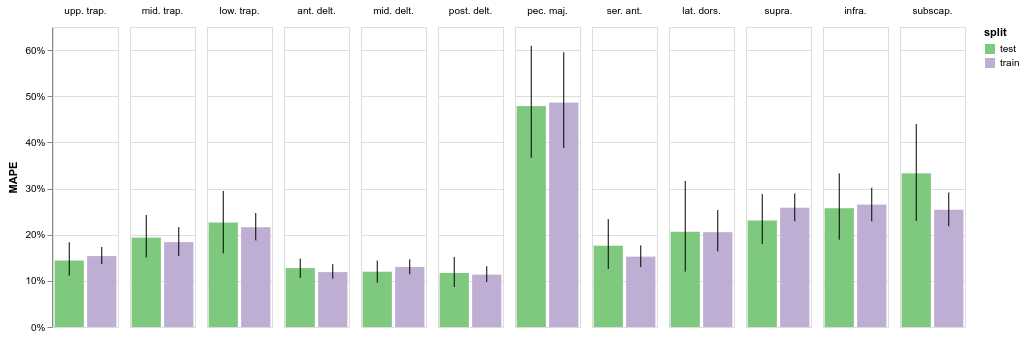

In [19]:
base = (
    alt.Chart()
    .encode(
        alt.X(
            "split",
            title=None,
            axis=alt.Axis(labels=False, domain=False, ticks=False),
            sort=["train", "test"],
        )
    )
    .properties(width=65)
)

bar = base.mark_bar().encode(
    alt.Y("mean(mape)", title="MAPE", axis=alt.Axis(format="%")), alt.Color("split", scale=alt.Scale(scheme='accent'))
)
error = base.mark_rule().encode(alt.Y("ci0(mape)"), alt.Y2("ci1(mape)"))


(bar + error).facet(data=eval_df, column=alt.Column("muscle", sort=MUSCLES, title=None))

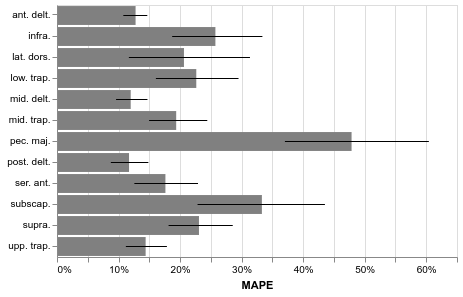

In [20]:
base = alt.Chart(test_eval).encode(alt.Y("muscle", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%"), title="MAPE")
)
error = base.mark_rule().encode(alt.X("ci0(mape)"), alt.X2("ci1(mape)"))

bar + error

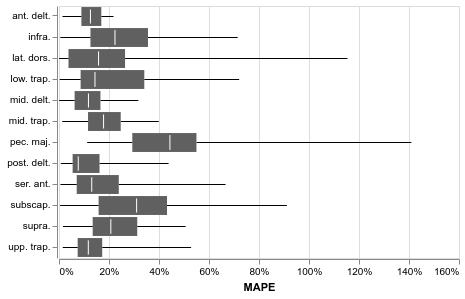

In [21]:
base = alt.Chart().encode(alt.Y("muscle", sort=MUSCLES, title=None))

bar = base.mark_bar(color="#606060").encode(
    alt.X("q1(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.X2("q3(mape)")
)
lower = base.mark_rule().encode(alt.X("min(mape)"), alt.X2("q1(mape)"))
upper = base.mark_rule().encode(alt.X("q3(mape)"), alt.X2("max(mape)"))
med = base.mark_tick(color='white').encode(alt.X("median(mape)"))

(upper + bar + med + lower).facet(data=test_eval)

In [22]:
mean_error = test_eval["mape"].mean()

error_vector = pd.DataFrame({"emg": np.linspace(0, 1, 100)}).assign(
    error=lambda x: x["emg"] * mean_error,
    error_upper=lambda x: x["emg"] + x["emg"] * mean_error,
    error_lower=lambda x: x["emg"] - x["emg"] * mean_error,
)

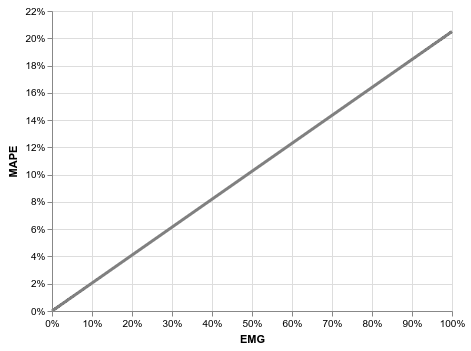

In [23]:
alt.Chart(error_vector).mark_line(color="grey", strokeWidth=3).encode(
    alt.X("emg", axis=alt.Axis(format="%", labelFlush=False), title="EMG"),
    alt.Y("error", title="MAPE", axis=alt.Axis(format="%")),
)

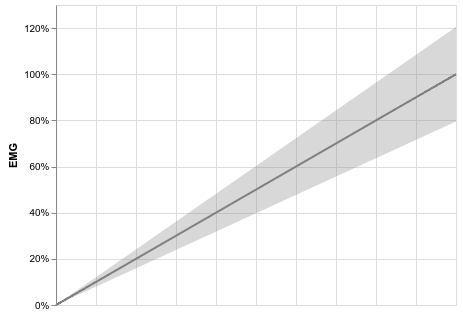

In [24]:
line = (
    alt.Chart(error_vector)
    .mark_line(color="grey")
    .encode(
        alt.X(
            "emg", title=None, axis=alt.Axis(labels=False, domain=False, ticks=False)
        ),
        alt.Y("emg", title="EMG", axis=alt.Axis(format="%")),
    )
)
area = (
    alt.Chart(error_vector)
    .mark_area(color="grey", opacity=0.3)
    .encode(alt.X("emg"), alt.Y("error_lower"), alt.Y2("error_upper"))
)
line + area

In [25]:
test_eval.head()

,mape,muscle,split
0,0.153306,ant. delt.,test
1,0.163881,lat. dors.,test
2,0.080087,low. trap.,test
3,0.172524,mid. delt.,test
4,0.399150,mid. trap.,test


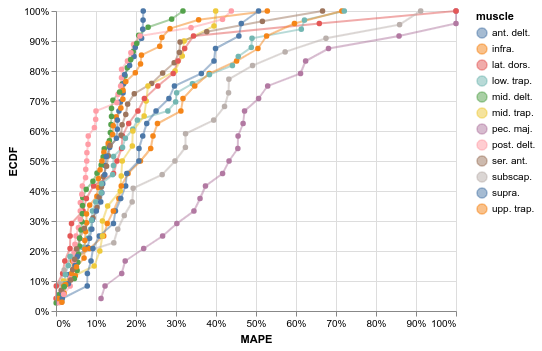

In [26]:
test_eval["ecdf"] = test_eval.groupby("muscle")["mape"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

alt.Chart(test_eval).mark_line(point=True, opacity=.5).encode(
    alt.X("mape", axis=alt.Axis(format="%"), title='MAPE', scale=alt.Scale(domain=[0, 1], clamp=True)),
    alt.Y("ecdf", axis=alt.Axis(format="%"), title='ECDF'),
    alt.Color("muscle"),
)

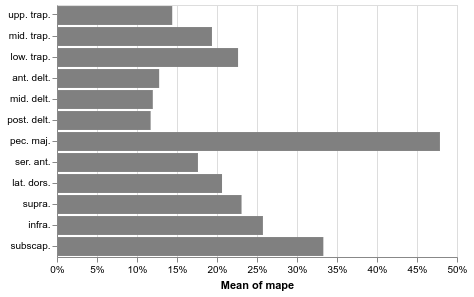

In [27]:
alt.Chart(test_eval).mark_bar(color="grey").encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%", labelFlush=False)),
    alt.Y("muscle", sort=MUSCLES, title=None),
)

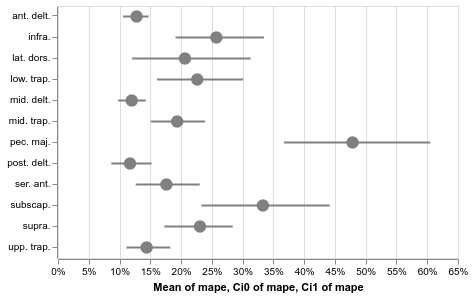

In [28]:
base = alt.Chart().encode(alt.Y("muscle", sort=MUSCLES, title=None))

p = base.mark_circle(color="grey", size=150).encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%", labelFlush=False))
)
c = base.mark_rule(color="grey", size=2).encode(alt.X("ci0(mape)"), alt.X2("ci1(mape)"))

(p + c).facet(data=test_eval)

# Part 4: Comparison with other studies

In [29]:
import pickle

RECOMMANDATIONS_PATH = MODEL_PATH / "recommandations.pkl"
if RECOMMANDATIONS_PATH.is_file():
    with open(RECOMMANDATIONS_PATH, "rb") as h:
        recommandations = pickle.load(h)
else:
    recommandations = {}

## Schwartz et al., 2017
[Schwartz et al., 2017](https://www.ncbi.nlm.nih.gov/pubmed/28841523)

In [30]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["S-9"] = {
        i: ["test 02", "test 03", 'test 04', 'test 05', 'test 06', 'test 10', 'test 12', 'test 14'] for i in MUSCLES
    }

## McDonald et al., 2017
[McDonald et al., 2017](https://www.tandfonline.com/doi/full/10.1080/23335432.2017.1308835?af=R)

In [31]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["M-8"] = {
        i: ["test 01", 'test 06', 'test 07', 'test 10', 'test 12', 'test 14', 'test 15'] for i in MUSCLES
    }

## Boettcher et al., 2008

[Boettcher et al., 2008](https://onlinelibrary.wiley.com/doi/abs/10.1002/jor.20675) identified a unique combinations of 4 MVIC tests to normalize 12 shoulder muscles

In [32]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["NT4"] = {
        i: ["test 12", "test 13", "test 14", "test 15"] for i in MUSCLES
    }

## Dal Maso et al., 2016

[Dal Maso et al., 2016](https://www.sciencedirect.com/science/article/pii/S0003999316000307)

### As published

In [33]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["DM"] = {
        "upp. trap.": ["test 01", "test 03", "test 05", "test 12"],
        "mid. trap.": [
            "test 02",
            "test 03",
            "test 08",
            "test 10",
            "test 12",
            "test 15",
        ],
        "low. trap.": ["test 02", "test 03", "test 05", "test 11", "test 15"],
        "ant. delt.": ["test 04", "test 05", "test 09", "test 12"],
        "mid. delt.": ["test 03", "test 09", "test 12", "test 15"],
        "post. delt.": ["test 02", "test 06"],
        "pec. maj.": ["test 08", "test 14"],
        "ser. ant.": ["test 03", "test 05", "test 07", "test 14", "test 15"],
        "lat. dors.": ["test 06", "test 07", "test 08", "test 11"],
        "supra.": ["test 01", "test 03", "test 05", "test 12"],
        "infra.": ["test 02", "test 03", "test 04", "test 15"],
        "subscap.": [
            "test 02",
            "test 03",
            "test 06",
            "test 10",
            "test 11",
            "test 15",
        ],
    }

### Implemented on our data

In [34]:
def compute_criterion(d, sets, thr):
    proportion = np.ones((sets.shape[0]))
    for i, iset in enumerate(sets):
        maximal_above_thr = d[iset].max(axis=1) > d.max(axis=1) * (thr / 100)
        proportion[i] = maximal_above_thr.sum() / d.shape[0] * 100

    sorted_idx = np.argsort(proportion)
    best_set = sets[sorted_idx][-1]
    best_proportion = proportion[sorted_idx][-1]
    return best_set, best_proportion

In [35]:
from itertools import combinations

THRESHOLD = 90
PERCENTILE = 90
TESTS = [i for i in df_wide.columns if i[:4] == "test"]

if RECOMMANDATIONS_PATH.is_file():
    print(recommandations["DM updated"])
else:
    recommandations["DM updated"] = {}
    for imuscle in MUSCLES:
        X_train_comp = df_wide.loc[X_train.index].query("muscle == @imuscle")[TESTS]
        print(f"{imuscle.upper()} ({X_train_comp.shape[0]} points)")

        for ntests in range(1, len(TESTS) + 1):
            sets = np.array(list(combinations(TESTS, ntests)))
            best_set, best_proportion = compute_criterion(X_train_comp, sets, thr=THRESHOLD)

            if best_proportion > PERCENTILE:
                print(f"\tno. of tests: {ntests}")
                print(f"\tbest set: {best_set}")
                print(f"\tproportion: {best_proportion:.2f}")
                print("-" * 10)
                recommandations["DM updated"][imuscle] = best_set
                break
    with open(RECOMMANDATIONS_PATH, "wb") as h:
        pickle.dump(recommandations, h)

{'upp. trap.': array(['test 01', 'test 03', 'test 05'], dtype='<U7'), 'mid. trap.': array(['test 02', 'test 03', 'test 05', 'test 10', 'test 15'], dtype='<U7'), 'low. trap.': array(['test 02', 'test 03', 'test 04', 'test 06', 'test 10'], dtype='<U7'), 'ant. delt.': array(['test 01', 'test 04', 'test 05', 'test 09', 'test 15', 'test 16'],
      dtype='<U7'), 'mid. delt.': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 06', 'test 09'],
      dtype='<U7'), 'post. delt.': array(['test 02', 'test 03', 'test 06'], dtype='<U7'), 'pec. maj.': array(['test 08', 'test 14'], dtype='<U7'), 'ser. ant.': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 15'], dtype='<U7'), 'lat. dors.': array(['test 06', 'test 07', 'test 11'], dtype='<U7'), 'supra.': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 06'], dtype='<U7'), 'infra.': array(['test 03', 'test 04', 'test 06', 'test 10', 'test 11', 'test 15',
       'test 16'], dtype='<U7'), 'subscap.': array(['test 03', 'test 04', 't

## Compare Boettcher & Dal Maso with our model

### MAPE for each method

In [36]:
recommandations["B-4"] = recommandations.pop("NT4")
recommandations["DM-14"] = recommandations.pop("DM")
# recommandations.pop('DM updated', None);

In [37]:
recommandations.keys()

dict_keys(['S-9', 'M-8', 'DM updated', 'B-4', 'DM-14'])

In [38]:
test_comparison = df_wide.drop(["dataset", "participant"], axis=1).loc[X_test.index]

r = []
for imuscle in MUSCLES:
    current = test_comparison.query("muscle == @imuscle").drop("muscle", axis=1)
    for imethod in recommandations.keys():
        r.append(
            mape_vector(
                current.max(axis=1),
                current[recommandations[imethod][imuscle]].max(axis=1),
            )
            .rename("mape")
            .to_frame()
            .assign(method=imethod, muscle=imuscle)
        )

df_comp = pd.concat(
    r + [test_eval.drop("split", axis=1).assign(method="P-3")], sort=False
)

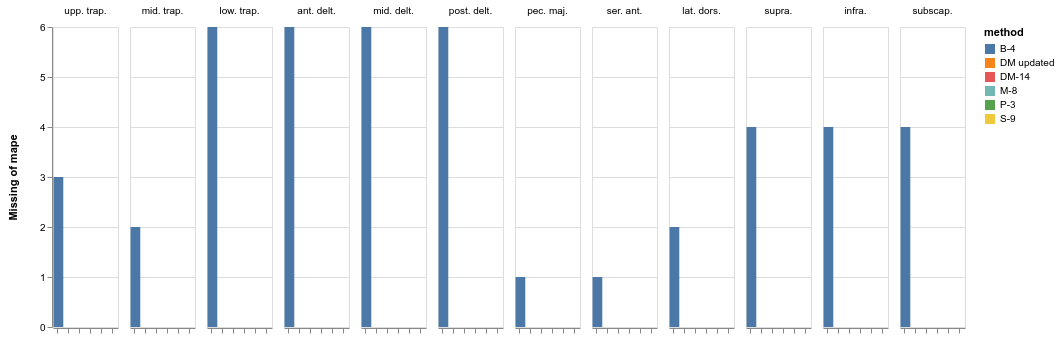

In [39]:
alt.Chart(df_comp).mark_bar().encode(
    alt.X("method", axis=alt.Axis(title="", labels=False)),
    alt.Y("missing(mape)"),
    alt.Color("method"),
    alt.Column("muscle", sort=MUSCLES, title=None),
).properties(width=65)

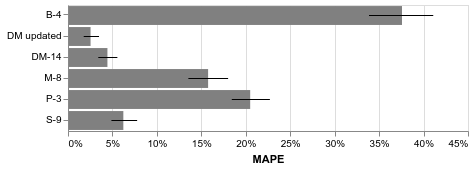

In [40]:
base = alt.Chart(df_comp).encode(alt.Y("method", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%"), title="MAPE")
)
error = base.mark_rule().encode(alt.X("ci0(mape)"), alt.X2("ci1(mape)"))

bar + error

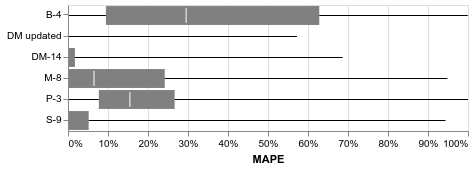

In [41]:
base = alt.Chart(df_comp).encode(alt.Y("method", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("q1(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.X2("q3(mape)")
)
med = base.mark_tick(color="white").encode(alt.X("median(mape)"))
upper = base.mark_rule().encode(
    alt.X("q3(mape)", scale=alt.Scale(domain=[0, 1], clamp=True)), alt.X2("max(mape)")
)
lower = base.mark_rule().encode(alt.X("min(mape)"), alt.X2("q1(mape)"))


bar + med + upper + lower

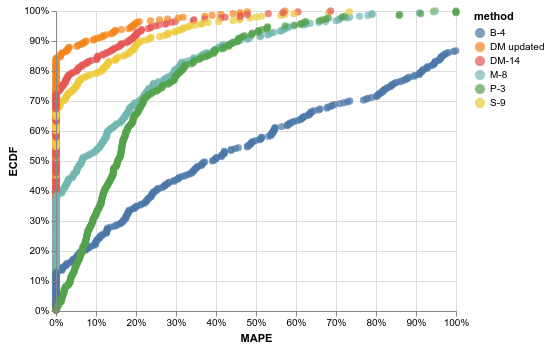

In [42]:
df_comp["ecdf"] = df_comp.groupby(["method"])["mape"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

alt.Chart(df_comp).mark_circle(size=50).encode(
    alt.X(
        "mape",
        axis=alt.Axis(format="%", labelFlush=False),
        title="MAPE",
        scale=alt.Scale(domain=[0, 1], clamp=True),
    ),
    alt.Y("ecdf", axis=alt.Axis(format="%"), title="ECDF"),
    alt.Color("method"),
)

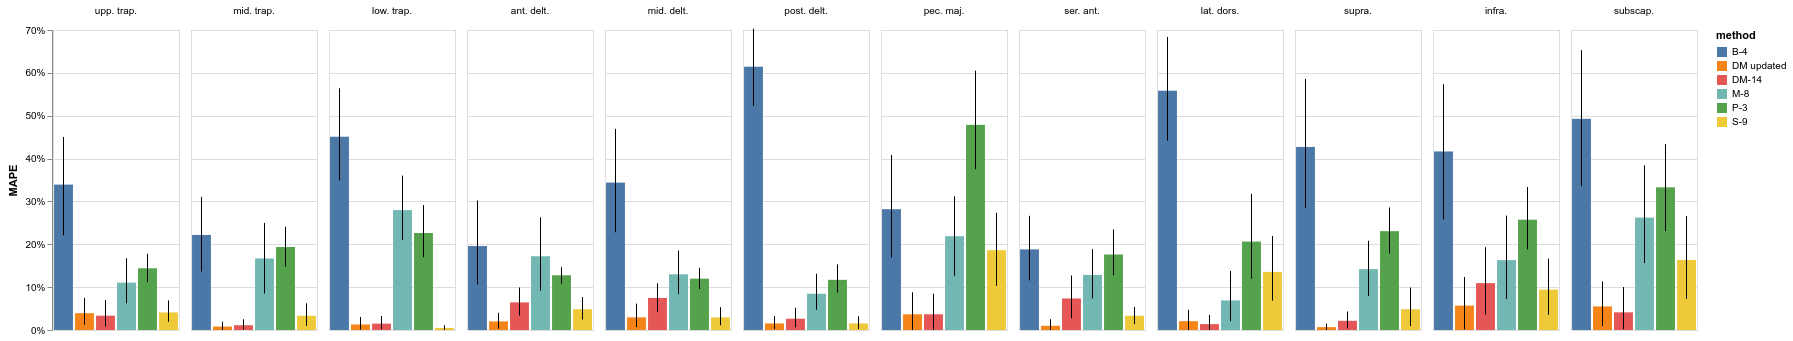

In [43]:
base = alt.Chart().encode(
    alt.X("method", axis=alt.Axis(title="", labels=False, ticks=False, domain=False))
)


bar = base.mark_bar().encode(
    alt.Y("mean(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.Color("method")
)
error = base.mark_rule().encode(alt.Y("ci0(mape)"), alt.Y2("ci1(mape)"))

(bar + error).facet(data=df_comp, column=alt.Column("muscle", sort=MUSCLES, title=None))

In [44]:
df_comp.dropna().shape

(1995, 4)

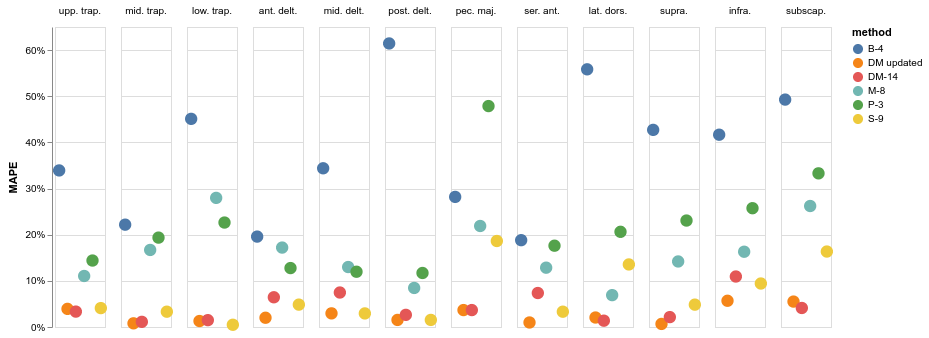

In [45]:
base = alt.Chart().encode(
    alt.X("method", axis=alt.Axis(ticks=False, labels=False, domain=False), title=None),
    alt.Color("method"),
)

p = base.mark_circle(size=150).encode(
    alt.Y("mean(mape)", axis=alt.Axis(format="%"), title="MAPE")
)
c = base.mark_rule(size=2).encode(alt.Y("ci0(mape)"), alt.Y2("ci1(mape)"))

(p.properties(width=50)).facet(data=df_comp, column=alt.Column("muscle", sort=MUSCLES, title=None))

### Compare execution time

In [46]:
time_by_test = 4  # min
time = {}
for imethod in recommandations.keys():
    c = []
    for imuscle, tests in recommandations[imethod].items():
        for itest in tests:
            if itest not in c:
                c.append(itest)
    time[imethod] = time_by_test * len(c)
time["P-3"] = time_by_test * 3
time = (
    pd.Series(time).rename("Execution time (min)").rename_axis("method").reset_index()
)

In [47]:
time

,method,Execution time (min)
0,S-9,32
1,M-8,28
2,DM updated,56
3,B-4,16
4,DM-14,56
5,P-3,12


In [48]:
(df_comp.groupby('method').agg(['mean', 'std']) * 100).round(2)

mape          ecdf       
             mean    std   mean    std
method                                
B-4         37.57  32.12  43.53  25.09
DM updated   2.54   8.04  50.15  28.91
DM-14        4.44  10.58  50.15  28.91
M-8         15.76  20.57  50.15  28.91
P-3         20.49  19.28  50.15  28.91
S-9          6.23  13.42  50.15  28.91

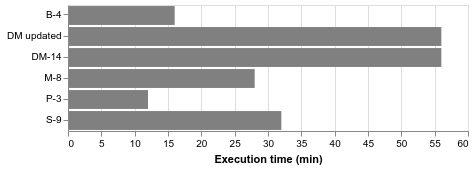

In [49]:
alt.Chart(time).mark_bar(color="grey").encode(
    alt.X("Execution time (min)"),
    alt.Y("method", title=None),
    alt.Tooltip("Execution time (min)"),
)

In [50]:
scatter_df = (
    df_comp.groupby("method")["mape"].mean().reset_index().merge(time, on="method")
).assign(
    dist_from_0=lambda x: np.sqrt(
        (x["mape"].multiply(100).pow(2) + x["Execution time (min)"].pow(2))
    ).round(2)
)

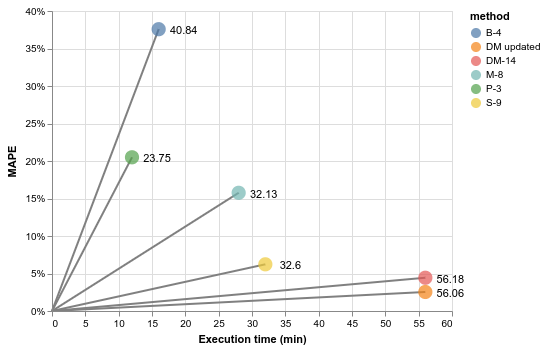

In [51]:
scatter = (
    alt.Chart(scatter_df)
    .mark_circle(size=200)
    .encode(
        alt.X("Execution time (min)", scale=alt.Scale()), alt.Y("mape", title="MAPE", axis=alt.Axis(format='%')), alt.Color("method")
    )
)

text = (
    alt.Chart(scatter_df)
    .mark_text(dx=25, dy=5)
    .encode(
        alt.X("Execution time (min)"), alt.Y("mape"), alt.Text('dist_from_0')
    )
)

dist_rule = (
    alt.Chart(
        pd.concat(
            [scatter_df, scatter_df.assign(**{"mape": 0, "Execution time (min)": 0})]
        )
    )
    .mark_line(color='grey')
    .encode(alt.X("Execution time (min)"), alt.Y("mape"), alt.Detail("method"))
)

dist_rule + scatter + text

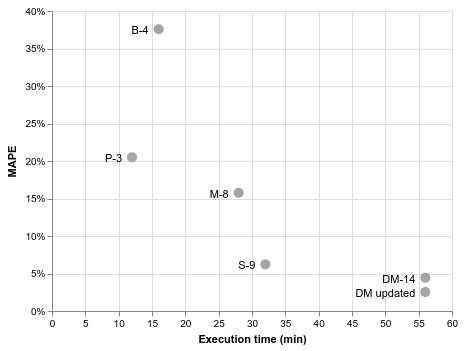

In [52]:
base = alt.Chart(scatter_df).encode(
    alt.X("Execution time (min)", axis=alt.Axis(labelFlush=False)),
    alt.Y("mape", title="MAPE", axis=alt.Axis(format="%")),
)

base.mark_circle(color="grey", size=100) + base.mark_text(
    dx=-10, dy=5, align="right"
).encode(alt.Text("method"))

In [53]:
def percentage_below_percentage(x, perc=0.1):
    return (x.dropna() < perc).sum() / x.dropna().shape[0] * 100

In [54]:
df_comp.groupby('method')['mape'].apply(percentage_below_percentage)

method
B-4           26.779661
DM updated    90.588235
DM-14         83.529412
M-8           53.529412
P-3           32.352941
S-9           79.117647
Name: mape, dtype: float64

### Bayesian Estimation Supersedes the T-Test

This model replicates the example used in: Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.

In [55]:
df_comp.to_csv('/home/romain/Downloads/df_comp.csv', index=False)

In [56]:
from itertools import combinations
from pathlib import Path

import numpy as np
import pandas as pd
import pymc3 as pm


def best(data, value, group):
    """
    This model replicates the example used in:
    Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.
    The original model is extended to handle multiple groups.

    Parameters
    ----------
    data: pandas.DataFrame
        Tidy pandas dataframe
    value: str
        Name of the column holding the values
    group: str
        Name of the column holding the groups
    Returns
    -------
    pymc3.Model
    """
    groups = data[group].unique()

    # pooled empirical mean of the data and twice the pooled empirical standard deviation
    mu = data[value].mean()
    sd = data[value].std() * 2

    # group standard deviations priors
    σ = [0.05, 0.5]

    with pm.Model() as model:
        groups_means = {
            igroup: pm.Normal(f"{igroup}_mean", mu=mu, sd=sd) for igroup in groups
        }
        groups_std = {
            igroup: pm.Uniform(f"{igroup}_std", lower=σ[0], upper=σ[-1])
            for igroup in groups
        }

        # prior for ν exponentially distributed with a mean of 30
        ν = pm.Exponential("ν_minus_one", lam=1 / 29.0) + 1

        # precision (transformed from standard deviations)
        λ = {igroup: groups_std[igroup] ** -2 for igroup in groups}

        likelihoods = {
            igroup: pm.StudentT(
                igroup,
                nu=ν,
                mu=groups_means[igroup],
                lam=λ[igroup],
                observed=data.query(f'{group} == "{igroup}"')[value].dropna(),
            )
            for igroup in groups
        }

        delta_means, delta_std, effect_size = {}, {}, {}
        for a, b in combinations(groups, 2):
            a_minus_b = f"{a} - {b}"
            delta_means[a_minus_b] = pm.Deterministic(
                f"Δμ ({a_minus_b})", groups_means[a] - groups_means[b]
            )
            delta_std[a_minus_b] = pm.Deterministic(
                f"Δσ ({a_minus_b})", groups_std[a] - groups_std[b]
            )
            effect_size[a_minus_b] = pm.Deterministic(
                f"effect size ({a_minus_b})",
                delta_means[a_minus_b]
                / np.sqrt((groups_std[a] ** 2 + groups_std[b] ** 2) / 2),
            )
    return model

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [61]:
SAMPLE = True
MODEL_PATH = Path("./model/stats")

trace = {}
for imuscle in MUSCLES:
    m = best(data=df_comp.query('muscle == @imuscle'), value="mape", group="method")
    with m:
        if SAMPLE:
            trace[imuscle] = pm.sample(10_000, tune=10_000, random_seed=RANDOM_SEED)
            pm.save_trace(trace[imuscle], directory=MODEL_PATH / imuscle, overwrite=True)
        else:
            trace[imuscle] = pm.load_trace(MODEL_PATH / imuscle, model=m)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, DM-14_std, B-4_std, P-3_mean, DM-14_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:40<00:00, 1985.13draws/s]
The acceptance probability does not match the target. It is 0.904689470478421, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, DM-14_std, B-4_std, P-3_mean, DM-14_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:44<00:00, 1801.89draws/s]
The acceptance probability does not match the target. It is 0.6766328052757721, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_

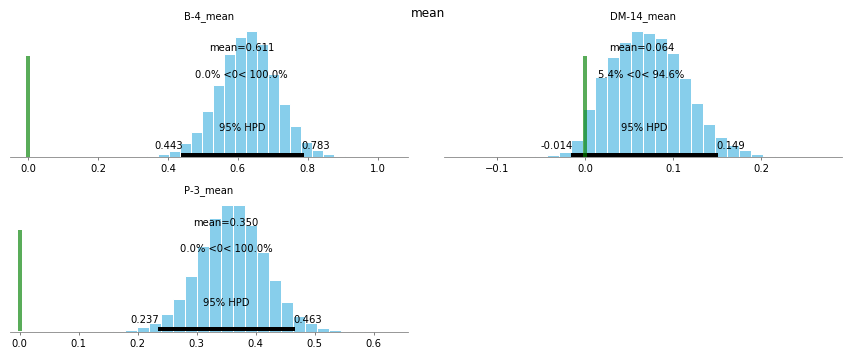

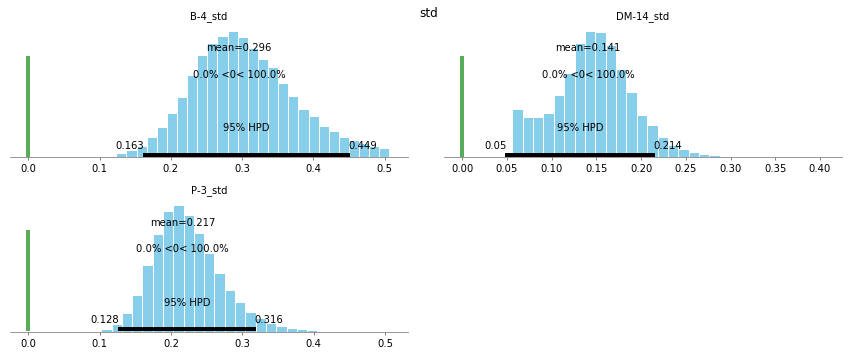

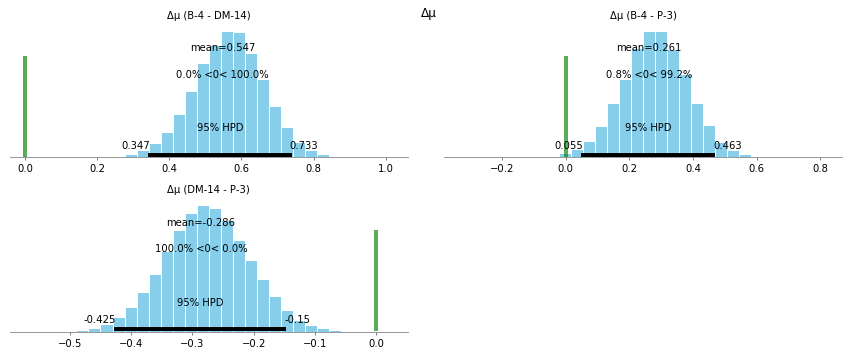

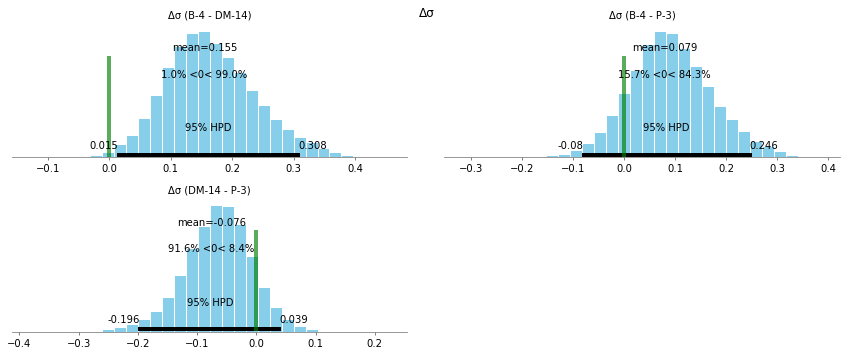

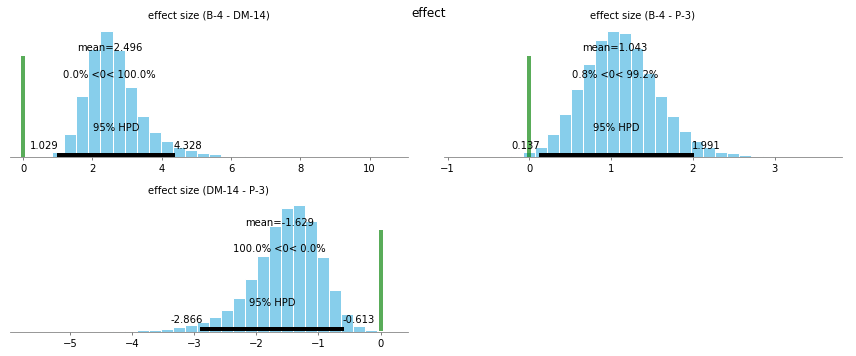

In [81]:
t = trace[MUSCLES[11]]
trace_vars = pm.trace_to_dataframe(t)
for ivar in ['mean', 'std', 'Δμ', 'Δσ', 'effect']:
    pm.plot_posterior(t, varnames=trace_vars.filter(like=ivar).columns, ref_val=0);
    plt.suptitle(ivar);

### Compare methods

In [57]:
df_comp.head()

,mape,method,muscle,ecdf
7,0.00000,S-9,upp. trap.,0.002941
143,0.00000,S-9,upp. trap.,0.005882
161,0.00000,S-9,upp. trap.,0.008824
215,0.18991,S-9,upp. trap.,0.867647
233,0.00000,S-9,upp. trap.,0.011765


In [64]:
SAMPLE = True
MODEL_PATH = "./models/ac_glm_methods"

formula = "mape ~ method"

imuscle = MUSCLES[0]
print(imuscle)

with pm.Model() as model:
    family = pm.glm.families.Normal()
    pm.glm.GLM.from_formula(
        formula,
        data=df_comp.query('muscle == @imuscle').eval('mape = (mape - mape.mean()) / mape.std()'),
        family=family,
    )
model

Chart({
  data:           dataset  participant       muscle     test       mvc
  0      Romain2017            0   upp. trap.  test 01  0.000381
  3      Romain2017            0   upp. trap.  test 04  0.000300
  4      Romain2017            0   upp. trap.  test 05  0.000348
  5      Romain2017            0   upp. trap.  test 06  0.000111
  8      Romain2017            0   upp. trap.  test 09  0.000249
  9      Romain2017            0   upp. trap.  test 10  0.000036
  10     Romain2017            0   upp. trap.  test 11  0.000011
  13     Romain2017            0   upp. trap.  test 14  0.000162
  48     Romain2017            0   ant. delt.  test 01  0.000471
  51     Romain2017            0   ant. delt.  test 04  0.000442
  52     Romain2017            0   ant. delt.  test 05  0.000430
  53     Romain2017            0   ant. delt.  test 06  0.000010
  56     Romain2017            0   ant. delt.  test 09  0.000237
  57     Romain2017            0   ant. delt.  test 10  0.000013
  58     Ro

In [321]:
with model:
    if SAMPLE:
        trace = pm.sample(10000, tune=2000)
        pm.save_trace(trace, directory=MODEL_PATH, overwrite=True)
    else:
        trace = pm.load_trace(MODEL_PATH, model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, method[T.P-3], method[T.DM-14], Intercept]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:20<00:00, 2343.87draws/s]


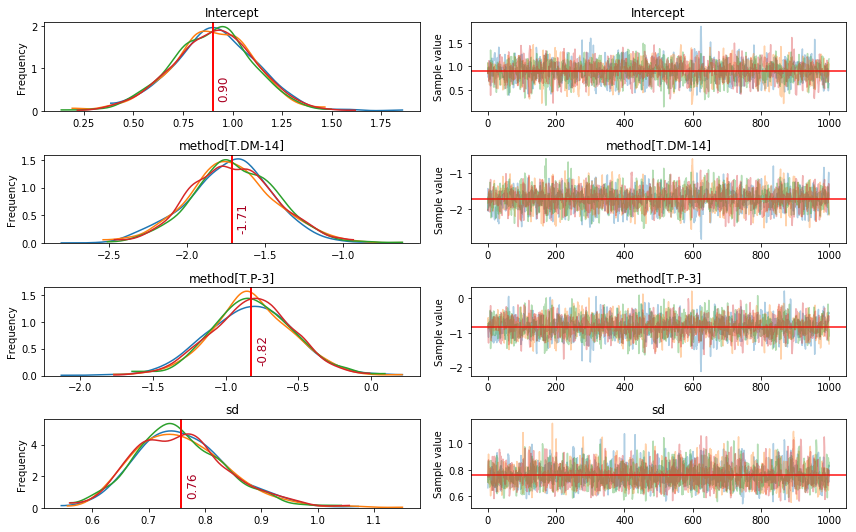

In [322]:
plot_traces(trace, retain=1000)

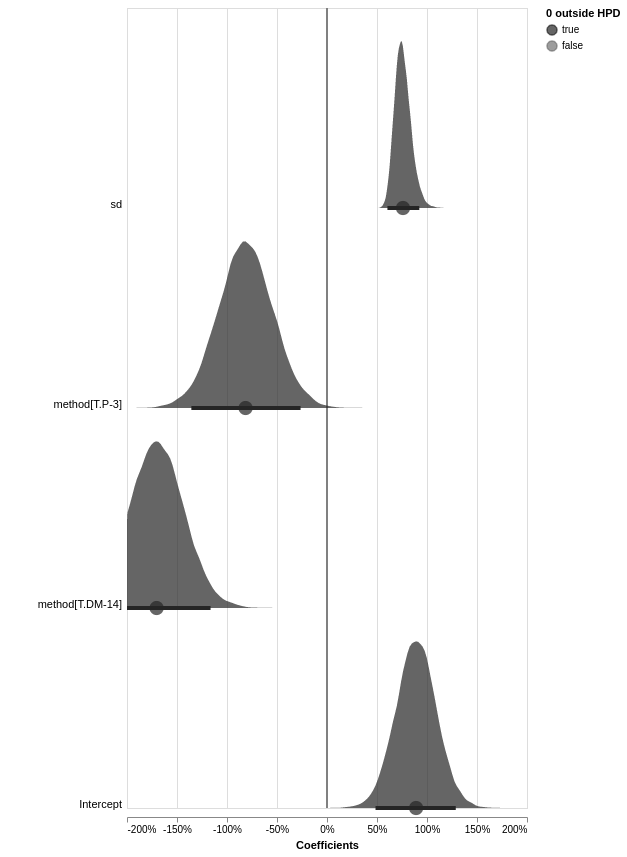

In [323]:
plot_bayes_violin(
    pm.trace_to_dataframe(trace),
    ref=0,
    domain=[-2, 2],
    xlabel="Coefficients",
    alpha=0.05,
    height=800
)

### Non-parametric stats

In [88]:
from sklearn.impute import SimpleImputer
import spm1d

ALPHA = 0.05 / (12 * 3)
N_ITER = 10000
p_value = {}

for imethod in combinations(set(df_comp["method"].unique()), 2):
    print(f"{imethod[0].upper()} vs. {imethod[1].upper()}")
    p_value[imethod] = {}
    for imuscle in MUSCLES:

        a = df_comp.query(f'muscle == "{imuscle}" & method == "{imethod[0]}"')[
            "mape"
        ].values.reshape(-1, 1)
        b = df_comp.query(f'muscle == "{imuscle}" & method == "{imethod[1]}"')[
            "mape"
        ].values.reshape(-1, 1)

        a = SimpleImputer(strategy="median").fit_transform(a)
        b = SimpleImputer(strategy="median").fit_transform(b)

        ttest = spm1d.stats.nonparam.ttest_paired(a.ravel(), b.ravel())
        ttesti = ttest.inference(alpha=ALPHA, iterations=N_ITER, two_tailed=True)

        if ttesti.h0reject:
            direction = ">" if a.mean() > b.mean() else "<"
            string = f"{imethod[0]} {direction} {imethod[1]}"
            p_value[imethod][imuscle] = ttesti.p
        else:
            string = "no differences"
            p_value[imethod][imuscle] = np.nan

        print(f"\t{imuscle}: {string}")

B-4 vs. P-3
	upper trapezius: B-4 > P-3
	middle trapezius: no differences
	lower trapezius: no differences
	anterior deltoid: no differences
	middle deltoid: B-4 > P-3
	posterior deltoid: B-4 > P-3
	pectoralis major: no differences
	serratus anterior: no differences
	latissimus dorsi: no differences
	supraspinatus: no differences
	infraspinatus: no differences
	subscapularis: no differences
B-4 vs. DM-14
	upper trapezius: B-4 > DM-14
	middle trapezius: B-4 > DM-14
	lower trapezius: B-4 > DM-14
	anterior deltoid: no differences
	middle deltoid: B-4 > DM-14
	posterior deltoid: B-4 > DM-14
	pectoralis major: B-4 > DM-14
	serratus anterior: B-4 > DM-14
	latissimus dorsi: B-4 > DM-14
	supraspinatus: B-4 > DM-14
	infraspinatus: no differences
	subscapularis: B-4 > DM-14
P-3 vs. DM-14
	upper trapezius: P-3 > DM-14
	middle trapezius: P-3 > DM-14
	lower trapezius: P-3 > DM-14
	anterior deltoid: no differences
	middle deltoid: no differences
	posterior deltoid: P-3 > DM-14
	pectoralis major: P-3

In [89]:
p = pd.DataFrame(p_value).T.reset_index()
p = (
    p.set_index(p["level_0"] + " vs " + p["level_1"])
    .drop(["level_0", "level_1"], axis=1)
    .T
)
p

,B-4 vs P-3,B-4 vs DM-14,P-3 vs DM-14
anterior deltoid,NaN,NaN,NaN
infraspinatus,NaN,NaN,NaN
latissimus dorsi,NaN,0.0001,0.0001
lower trapezius,NaN,0.0001,0.0001
middle deltoid,0.0002,0.0001,NaN
middle trapezius,NaN,0.0001,0.0001
pectoralis major,NaN,0.0001,0.0001
posterior deltoid,0.0001,0.0001,0.0001
serratus anterior,NaN,0.0002,NaN
subscapularis,NaN,0.0002,NaN


In [90]:
pd.cut(
    p.stack(),
    bins=[-np.inf, 0.0001, 0.001, 0.01, 0.05, np.inf],
    labels=["****", "***", "**", "*", "ns"],
).unstack()

,B-4 vs P-3,B-4 vs DM-14,P-3 vs DM-14
latissimus dorsi,NaN,****,****
lower trapezius,NaN,****,****
middle deltoid,***,****,NaN
middle trapezius,NaN,****,****
pectoralis major,NaN,****,****
posterior deltoid,****,****,****
serratus anterior,NaN,***,NaN
subscapularis,NaN,***,NaN
supraspinatus,NaN,****,NaN
upper trapezius,***,****,***
